# Representing Hypercomplex Numbers

In this notebook, we build up a structure for representing and manipulating vectors of muli dimensional numbers from clifford algebras. We particulartly focus on set of hypercomplex numbers.

Consider a hypercomplex number $ z $ that can be expressed as a sum of weights of various unit variables in the hypercomplex basis $ e_0, e_1, \cdots , e_n $ given below.

$ z = a_0 e_0 + a_1 e_1 + \cdots + a_n e_n $

We can express such a number z as the following inner product. 
Recall the dot product is a commutative operationwhen at least one vector contains only real numbers.

$ z = \hat{a}^T \hat{e} = \hat{e}^T \hat{a} $, $ \hat{a} = \begin{bmatrix} a_0 \\ a_1 \\ \vdots \\ a_n \end{bmatrix} $, $ \hat{e} = \begin{bmatrix} e_0 \\ e_1 \\ \vdots \\ e_n \end{bmatrix}  $

Consider taking the conjugate of number z. The conjugate of a multiplication between vectors $\hat{a}$ and $\hat{e}$ distributes to each factor, but recall that $\hat{a}$ contains only real numbers, and thus we have the following.

$ \overline{z} = \overline{\hat{a}^T \hat{e}} = \overline{\hat{a}}^T \overline{\hat{e}} = \hat{a}^T \overline{\hat{e}} $

Given these identities, we can gradient of z with respect to the vector $\hat{a}$ which is given below. Recall that the gradient of a scalar with respect to a vector is a vector.

$ \frac{d}{d \hat{a}} z = \frac{d}{d \hat{a}} \hat{a}^T \hat{e} = \hat{e} $

Similarly, we can compute the gradient with respect to the coefficient vector $\hat{a}$ when conjugating z.


$ \frac{d}{d \hat{a}} \overline{z} = \frac{d}{d \hat{a}} \hat{a}^T \overline{\hat{e}} = \overline{\hat{e}} $


## Cayley Dickson Recursive Multiplication

The Cayley-Dickson construction is describes a hypercomplex number as a tuple of two hypercomplex numbers of half the dimensionality. See the following description.

$ z = (a, b) $, $ w = (c, d) $

We can then compute the multiplication of two hypercomplex numbers by applying the following recursive discription in order to reduce this multiplication into summation of products of real coefficients.

$ z w = (a, b) (c, d) = (a c - \overline{d} b, da + b \overline{c}) $

In [38]:
M = 4

class Symbol:
    
    def join(a, b, delimiter):
        return Symbol("(" + str(a) + " " + str(delimiter) + " " + str(b) + ")")
    
    def __init__(self, name):
        self.name = name
        
    def __str__(self):
        return str(self.name)
    
    def __repr__(self):
        return str(self.name)
    
    def __add__(self, a):
        return Symbol.join(self, a, "+")
    
    def __sub__(self, a):
        return Symbol.join(self, a, "-")
    
    def __mul__(self, a):
        return Symbol.join(self, a, "*")
    
    def __truediv__(self, a):
        return Symbol.join(self, a, "/")


def hypercomplex_conjugate(a):
    return [a[0]] + [Symbol("-1") * a[i] for i in range(1, len(a))]
    

def hypercomplex_multiply(a, b):
    if len(a) == len(b) == 1:
        return [a[0] * b[0]]
    else:
        def cayley_dickson(p, q, r, s):
            p1 = hypercomplex_multiply(p, r)
            p2 = hypercomplex_multiply(hypercomplex_conjugate(s), q)
            p3 = hypercomplex_multiply(s, p)
            p4 = hypercomplex_multiply(q, hypercomplex_conjugate(r))
            left = [a - b for a, b in zip(p1, p2)]
            right = [a + b for a, b in zip(p3, p4)]
            return (left + right)
        return cayley_dickson(
            a[:(len(a) // 2)],
            a[(len(a) // 2):],
            b[:(len(b) // 2)],
            b[(len(b) // 2):])
    
    
z = [Symbol("a_" + str(x)) for x in range(M)]
w = [Symbol("b_" + str(x)) for x in range(M)]
product = hypercomplex_multiply(z, w)
    
    
for i in range(M):
    print("Element", i) 
    print(str(product[i]) + "\n")    
    

Element 0
(((a_0 * b_0) - (b_1 * a_1)) - ((b_2 * a_2) - (a_3 * (-1 * b_3))))

Element 1
(((b_1 * a_0) + (a_1 * b_0)) - ((a_3 * b_2) + ((-1 * b_3) * a_2)))

Element 2
(((b_2 * a_0) - (a_1 * b_3)) + ((a_2 * b_0) - ((-1 * b_1) * a_3)))

Element 3
(((a_1 * b_2) + (b_3 * a_0)) + (((-1 * b_1) * a_2) + (a_3 * b_0)))



## Binding Hypercomplex Numbers

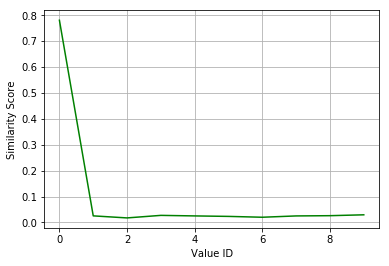

Value Maximum Similarity: 0


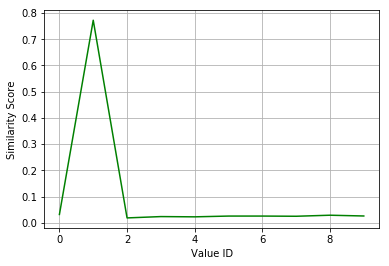

Value Maximum Similarity: 1


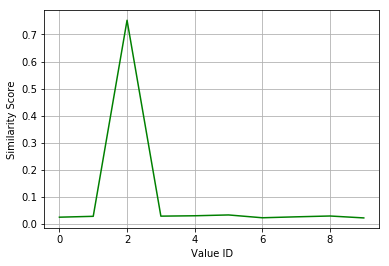

Value Maximum Similarity: 2


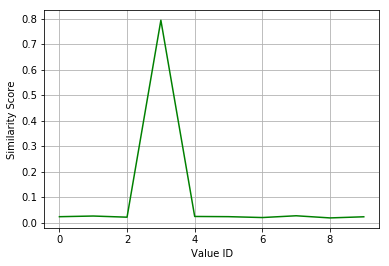

Value Maximum Similarity: 3


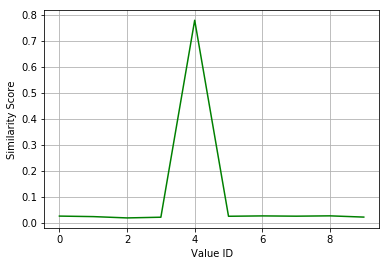

Value Maximum Similarity: 4


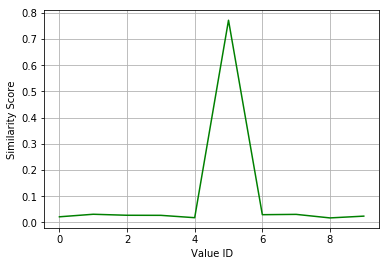

Value Maximum Similarity: 5


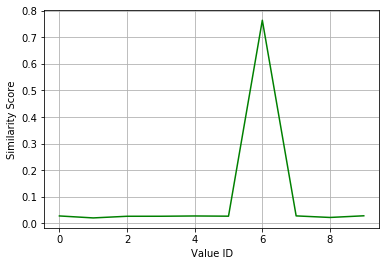

Value Maximum Similarity: 6


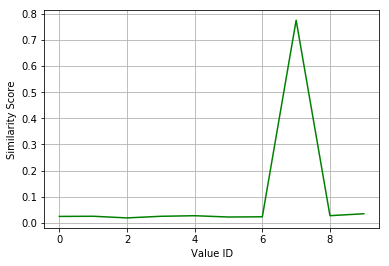

Value Maximum Similarity: 7


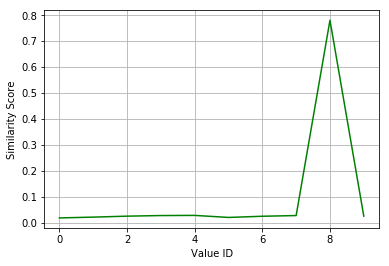

Value Maximum Similarity: 8


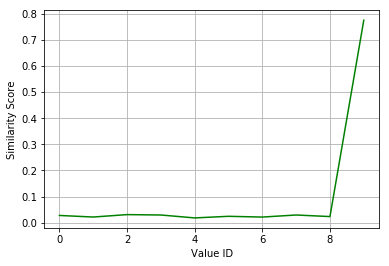

Value Maximum Similarity: 9


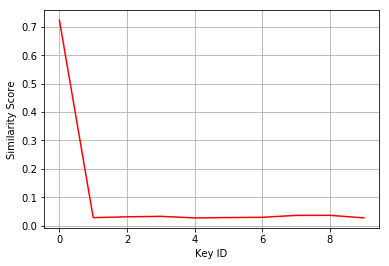

Key Maximum Similarity: 0


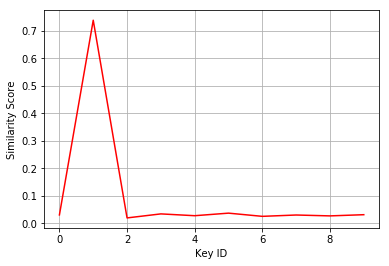

Key Maximum Similarity: 1


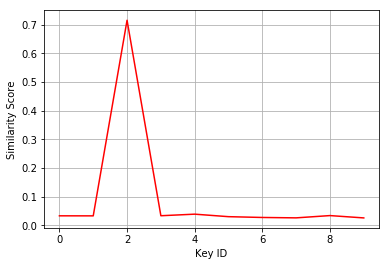

Key Maximum Similarity: 2


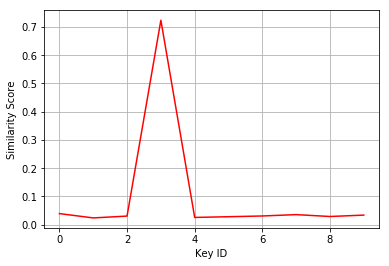

Key Maximum Similarity: 3


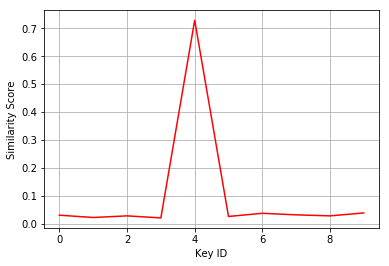

Key Maximum Similarity: 4


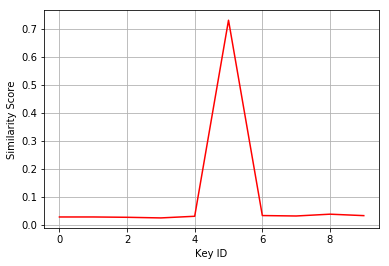

Key Maximum Similarity: 5


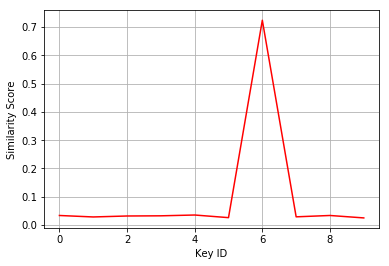

Key Maximum Similarity: 6


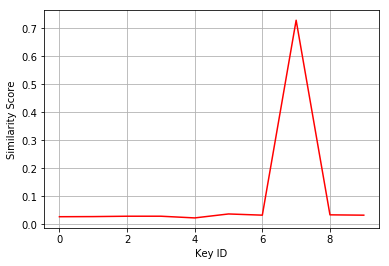

Key Maximum Similarity: 7


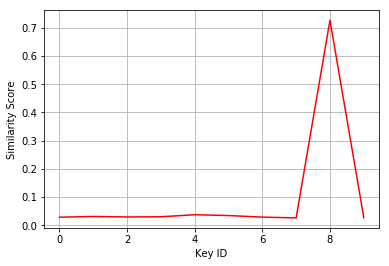

Key Maximum Similarity: 8


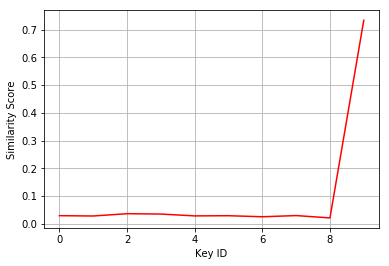

Key Maximum Similarity: 9


In [44]:
import numpy as np
import matplotlib.pyplot as plt


N = 10000
S = 10
M = 16


keys = []
for _ in range(S):
    rows = np.random.normal(0.0, 1.0, (N, M))
    row_magnitudes = np.sum(rows * rows, axis=1, keepdims=True)**(1/2)
    k = rows / row_magnitudes
    keys += [k]

    
values = []
for _ in range(S):
    rows = np.random.normal(0.0, 1.0, (N, M))
    row_magnitudes = np.sum(rows * rows, axis=1, keepdims=True)**(1/2)
    v = rows / row_magnitudes
    values += [v]


def hypercomplex_conjugate(a, m=M):
    if m == 1:
        return a
    else:
        return np.concatenate([
            hypercomplex_conjugate(a[..., :(m - 1)], m=(m - 1)),
            (-1 * a[..., (m - 1):m])
        ], axis=(len(a.shape) - 1))

    
def hypercomplex_multiply(a, b, m=M):
    if m == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r,
                    m=(m//2)) -
                 hypercomplex_multiply(
                     hypercomplex_conjugate(s, m=(m//2)),
                     q,
                     m=(m//2))),
                (hypercomplex_multiply(
                    s,
                    p,
                    m=(m//2)) +
                 hypercomplex_multiply(
                     q,
                     hypercomplex_conjugate(r, m=(m//2)),
                     m=(m//2))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(m//2)],
            a[..., (m//2):],
            b[..., :(m//2)],
            b[..., (m//2):])

    
def hypercomplex_dot(a, b, m=M):
    return np.sum(
        hypercomplex_multiply(
            hypercomplex_conjugate(a, m=m), 
            b, m=m), axis=0, keepdims=True)


def hypercomplex_magnitude(a, m=M):
    return np.sqrt(np.sum(a * a, axis=1, keepdims=True))
    
    
superposition = np.zeros((N, M))
for k, v in zip(keys, values):
    superposition += hypercomplex_multiply(k, v)
    

for k in keys:
    recovered = hypercomplex_multiply(hypercomplex_conjugate(k), superposition)
    
    probabilities = np.zeros((0, 1))
    for v in values:
        similarity = hypercomplex_magnitude(hypercomplex_dot(recovered, v))
        probabilities = np.vstack([probabilities, similarity])
    probabilities /= np.sum(probabilities)
    
    plt.plot(probabilities, "g")
    plt.xlabel("Value ID")
    plt.ylabel("Similarity Score")
    plt.grid(True)
    plt.show()
    selected = np.argmax(probabilities)
    print("Value Maximum Similarity:", selected)
    
    
for v in values:
    recovered = hypercomplex_multiply(hypercomplex_conjugate(superposition), v)
    
    probabilities = np.zeros((0, 1))
    for k in keys:
        similarity = hypercomplex_magnitude(hypercomplex_dot(k, recovered))
        probabilities = np.vstack([probabilities, similarity])
    probabilities /= np.sum(probabilities)
    
    plt.plot(probabilities, "r")
    plt.xlabel("Key ID")
    plt.ylabel("Similarity Score")
    plt.grid(True)
    plt.show()
    selected = np.argmax(probabilities)
    print("Key Maximum Similarity:", selected)

## The Hypercomplex Fourier Transform

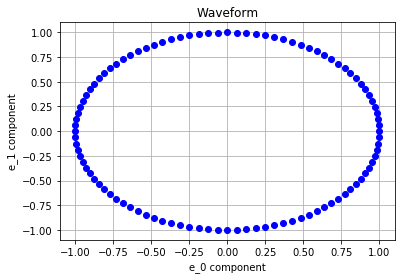

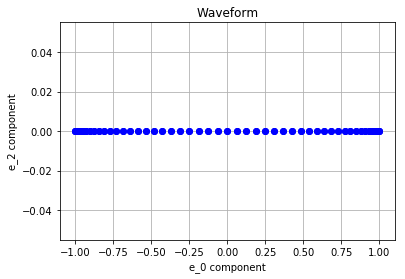

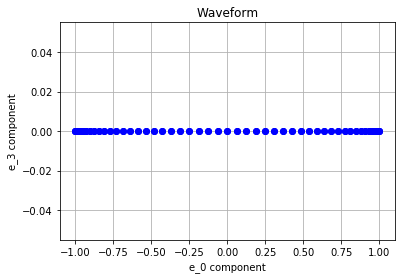

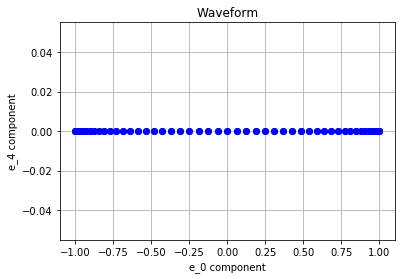

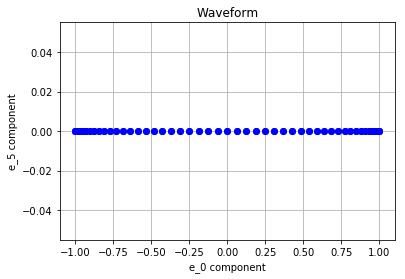

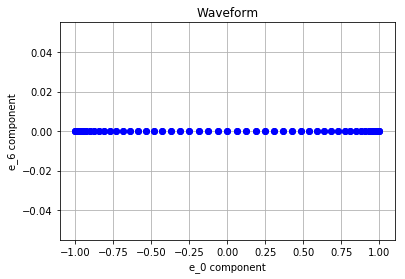

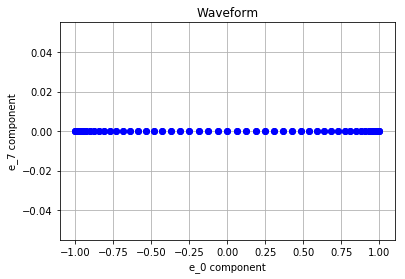

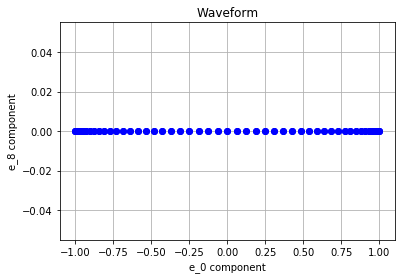

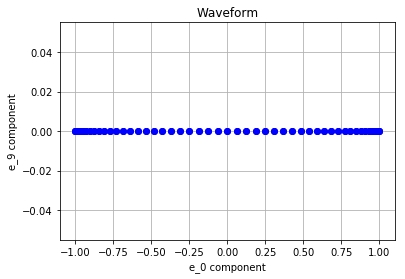

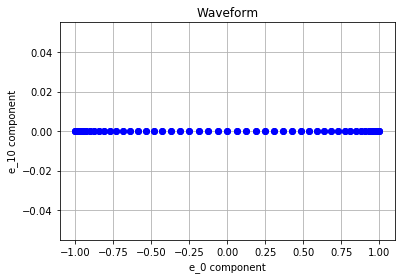

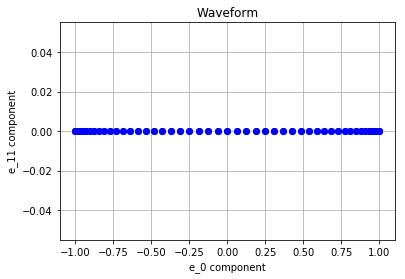

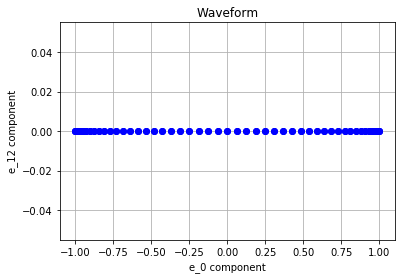

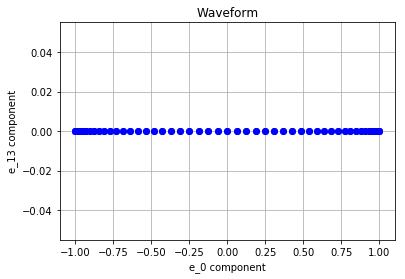

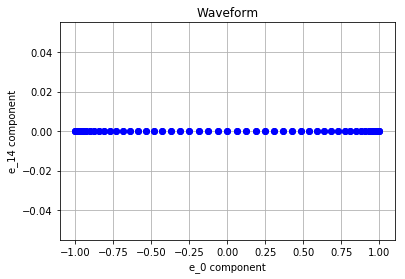

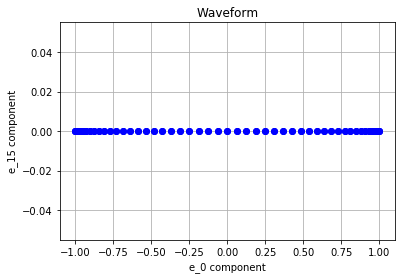

In [42]:
import numpy as np
import matplotlib.pyplot as plt


N = 100
M = 16

def hypercomplex_conjugate(a, m=M):
    if m == 1:
        return a[...]
    else:
        return np.concatenate([
            hypercomplex_conjugate(a[..., :(m - 1)], m=(m - 1)),
            (-1 * a[..., (m - 1):m])
        ], axis=(len(a.shape) - 1))

    
def hypercomplex_multiply(a, b, m=M):
    if m == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r,
                    m=(m//2)) -
                 hypercomplex_multiply(
                     hypercomplex_conjugate(s, m=(m//2)),
                     q,
                     m=(m//2))),
                (hypercomplex_multiply(
                    s,
                    p,
                    m=(m//2)) +
                 hypercomplex_multiply(
                     q,
                     hypercomplex_conjugate(r, m=(m//2)),
                     m=(m//2))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(m//2)],
            a[..., (m//2):],
            b[..., :(m//2)],
            b[..., (m//2):])
    
    
def hypercomplex_dft(a, n=N, m=M, v=np.ones(M)):
    def hypercomplex_euler():
        coefficients = np.dot(
            np.arange(n).reshape((n, 1)),
            np.arange(n).reshape((1, n))).reshape((n, n, 1))
        amplitude = np.exp(v[0] * 2 * np.pi * coefficients / n)
        magnitude = np.sqrt(np.sum(v[1:] * v[1:]))
        return np.concatenate([
            (amplitude * np.cos(2 * np.pi * coefficients * magnitude / n)),
            (np.tile(
                amplitude * np.sin(2 * np.pi * coefficients * magnitude / n) / magnitude, 
                (1, 1, (m - 1))) * v[1:].reshape((1, 1, (m - 1))))], axis=2)
    return np.sum(
        hypercomplex_multiply(
            1 / hypercomplex_euler(), 
            np.tile(
                a.reshape((n, 1, m)),
                (1, n, 1)),
            m=m), axis=0) / n


def hypercomplex_idft(a, n=N, m=M, v=np.ones(M)):
    def hypercomplex_euler():
        coefficients = np.dot(
            np.arange(n).reshape((n, 1)),
            np.arange(n).reshape((1, n))).reshape((n, n, 1))
        amplitude = np.exp(v[0] * 2 * np.pi * coefficients / n)
        magnitude = np.sqrt(np.sum(v[1:] * v[1:]))
        return np.concatenate([
            (amplitude * np.cos(2 * np.pi * coefficients * magnitude / n)),
            (np.tile(
                amplitude * np.sin(2 * np.pi * coefficients * magnitude / n) / magnitude, 
                (1, 1, (m - 1))) * v[1:].reshape((1, 1, (m - 1))))], axis=2)
    return np.sum(
        hypercomplex_multiply(
            hypercomplex_euler(),
            np.tile(
                a.reshape((n, 1, m)),
                (1, n, 1)),
            m=m), axis=0)


test_kernel = np.zeros(M)
test_kernel[1] = 1


frequency = np.zeros((N, M))
frequency[1, 0] = 1
waveform = hypercomplex_idft(frequency, v=test_kernel)


for i in range(1, M):
    plt.plot(waveform[:, 0], waveform[:, i], "bo")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("Waveform")
    plt.grid(True)
    plt.show()
    

## Gradient Descent with Hypercomplex Numbers

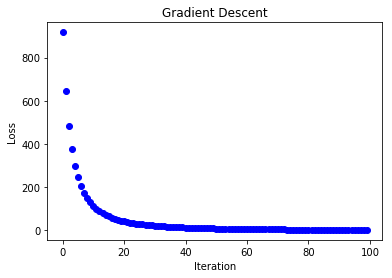

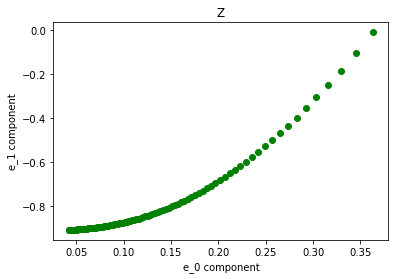

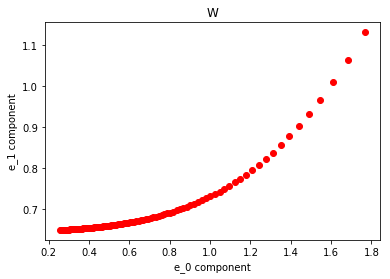

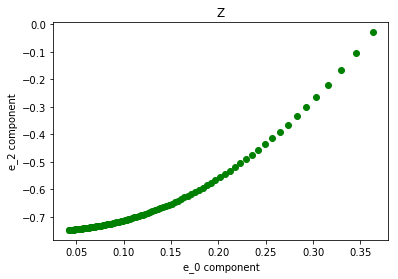

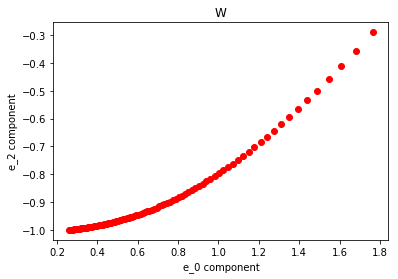

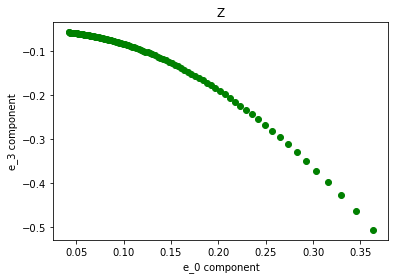

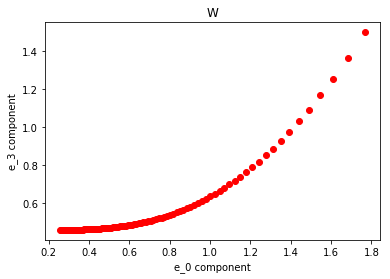

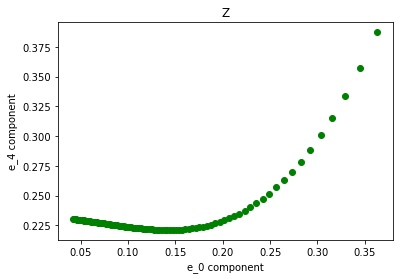

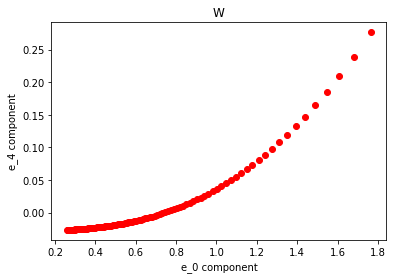

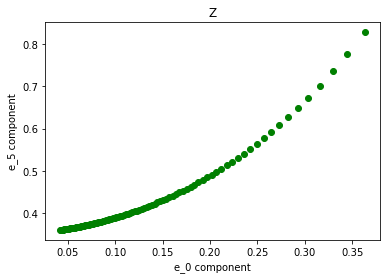

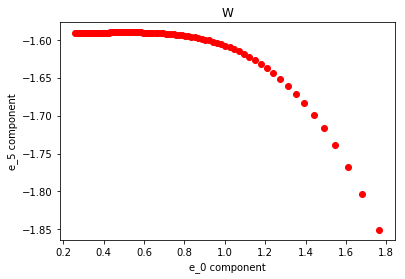

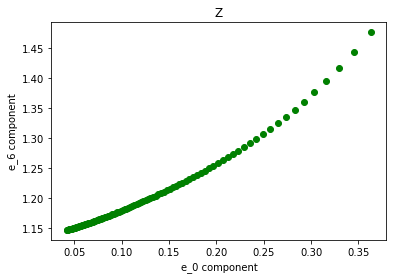

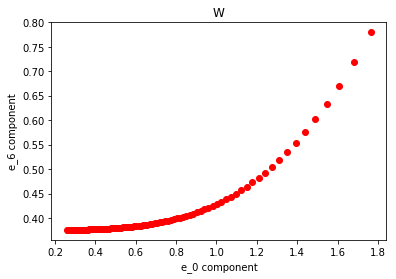

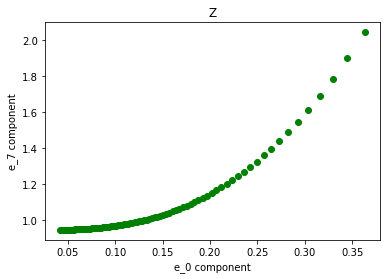

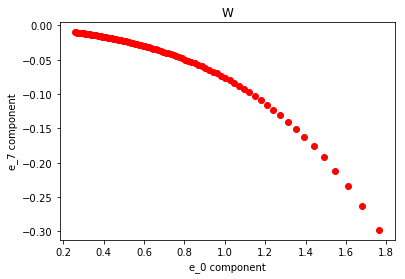

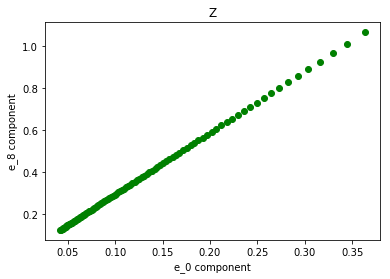

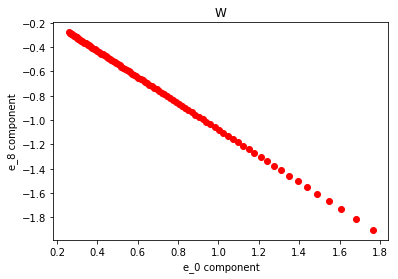

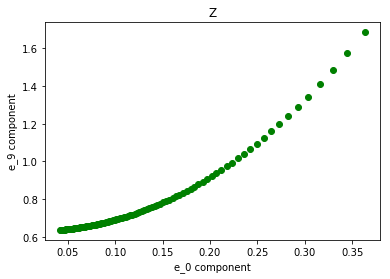

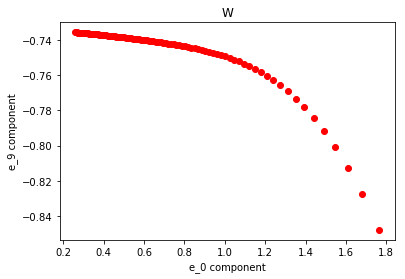

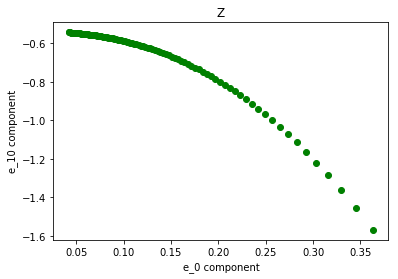

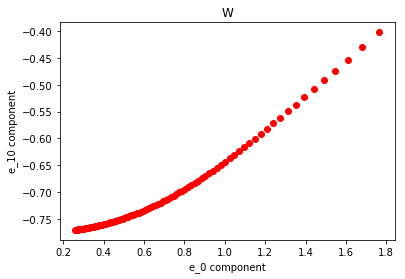

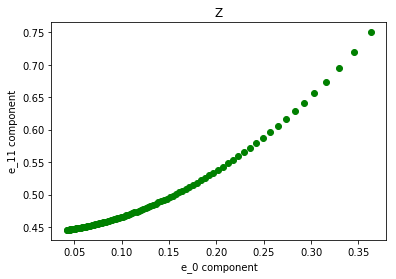

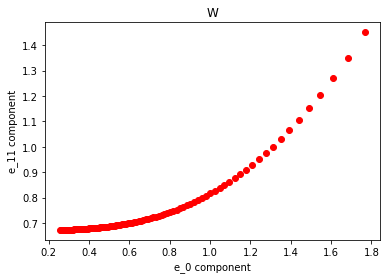

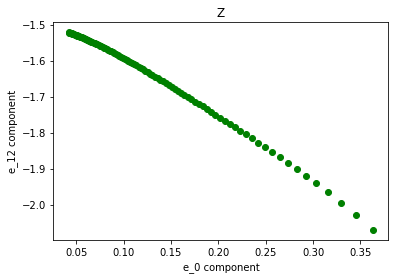

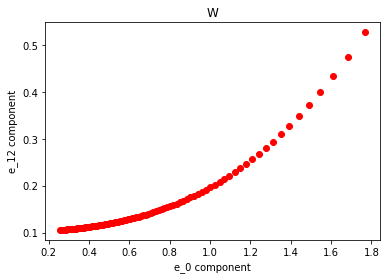

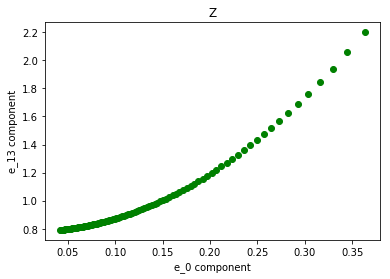

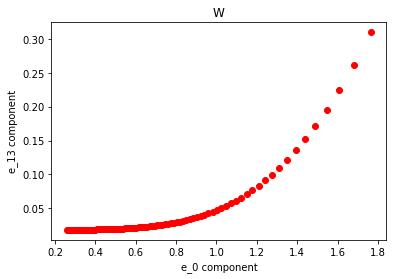

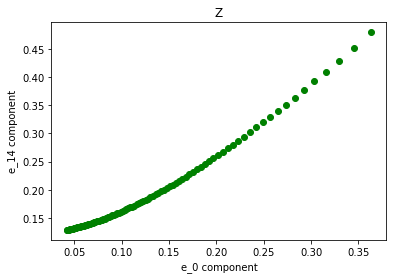

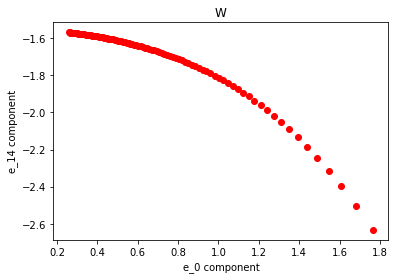

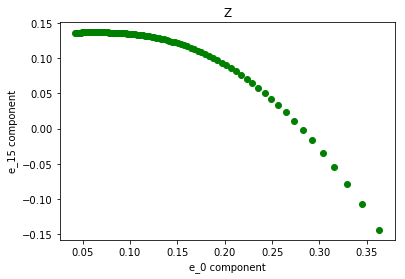

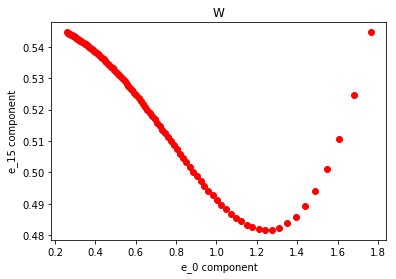

In [45]:
import numpy as np
import matplotlib.pyplot as plt


N = 1
M = 16
A = 0.001
E = 100


def hypercomplex_conjugate(a):
    c = np.ones(a.shape)
    c[..., 1:] *= -1
    return c * a
    
    
def hypercomplex_conjugate_gradient(a, da):
    return hypercomplex_conjugate(da)
    

def hypercomplex_multiply(a, b):
    if a.shape[-1] == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r) -
                hypercomplex_multiply(
                    hypercomplex_conjugate(s),
                    q)),
                (hypercomplex_multiply(
                    s,
                    p) +
                hypercomplex_multiply(
                    q,
                    hypercomplex_conjugate(r))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(a.shape[-1] // 2)],
            a[..., (a.shape[-1] // 2):],
            b[..., :(a.shape[-1] // 2)],
            b[..., (a.shape[-1] // 2):])
    
    
def hypercomplex_multiply_gradient(a, b, da, db):
    return (hypercomplex_multiply(da, b),
        hypercomplex_multiply(a, db))
    

def hypercomplex_basis_gradient(a):
    basis = np.zeros((a.shape[-1], a.shape[-1]))
    np.fill_diagonal(basis, 1)
    basis = basis.reshape((1, a.shape[-1], a.shape[-1]))
    return basis
    

z = np.random.normal(0, 1, (N, 1, M))
w = np.random.normal(0, 1, (N, 1, M))
basis = hypercomplex_basis_gradient(z)

datapoints_z = []
datapoints_w = []
datapoints_loss = []


for _ in range(E):
    
    m = hypercomplex_multiply(z, w)
    m_c = hypercomplex_conjugate(m)
    r = hypercomplex_multiply(m, m_c)
    loss = np.sum(r[:, :, 0])
    
    dm_dz, dm_dw = hypercomplex_multiply_gradient(z, w, basis, basis)
    dm_dz_c, dm_dw_c = hypercomplex_conjugate(dm_dz), hypercomplex_conjugate(dm_dw)
    
    dr_dm_dz, dr_dm_dz_c = hypercomplex_multiply_gradient(m, m_c, dm_dz, dm_dz_c)
    dr_dm_dw, dr_dm_dw_c = hypercomplex_multiply_gradient(m, m_c, dm_dw, dm_dw_c)
    
    dr_dz = dr_dm_dz + dr_dm_dz_c # Apply the product rule
    dr_dz = dr_dz[:, :, 0].reshape((N, 1, M)) # Take the real component
    
    dr_dw = dr_dm_dw + dr_dm_dw_c # Apply the product rule
    dr_dw = dr_dw[:, :, 0].reshape((N, 1, M)) # Take the real component
    
    z -= A * dr_dz
    w -= A * dr_dw
    
    datapoints_z += [[z[0, 0, i] for i in range(M)]]
    datapoints_w += [[w[0, 0, i]for i in range(M)]]
    datapoints_loss += [loss]
    
    
datapoints_z = np.array(datapoints_z)
datapoints_w = np.array(datapoints_w)
datapoints_loss = np.array(datapoints_loss)


plt.plot(datapoints_loss, "bo")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Gradient Descent")
plt.show()

for i in range(1, M):
    
    plt.plot(datapoints_z[:, 0], datapoints_z[:, i], "go")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("Z")
    plt.show()
    
    plt.plot(datapoints_w[:, 0], datapoints_w[:, i], "ro")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("W")
    plt.show()


## Hypercomplex Neural Networks

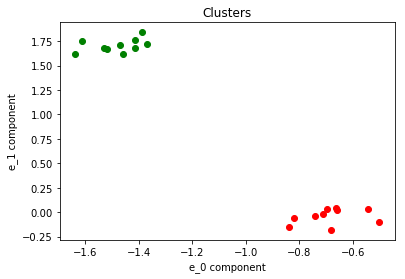

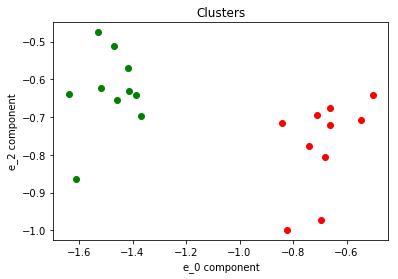

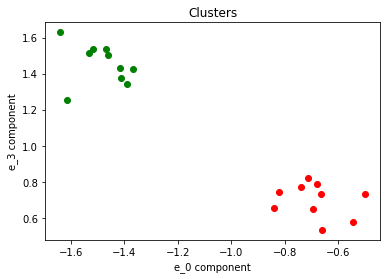

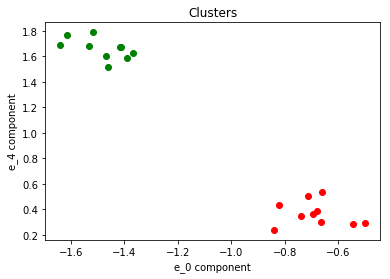

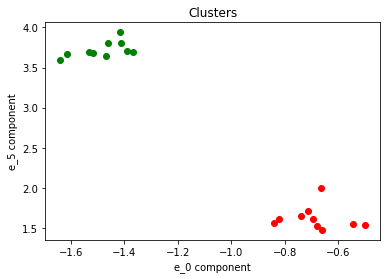

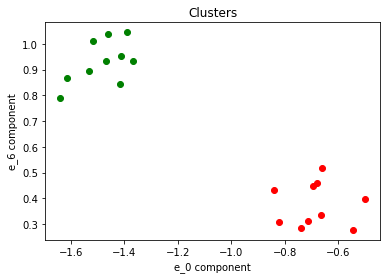

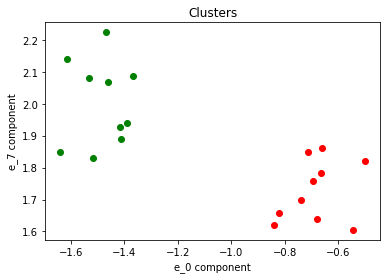

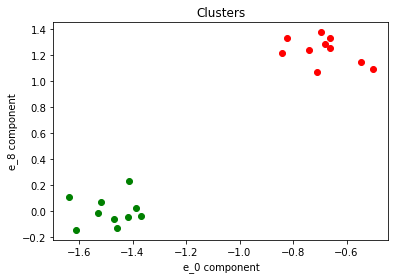

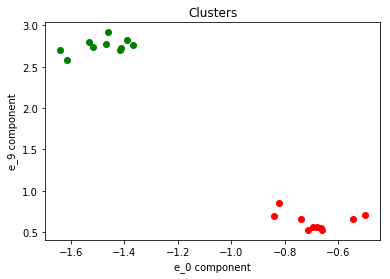

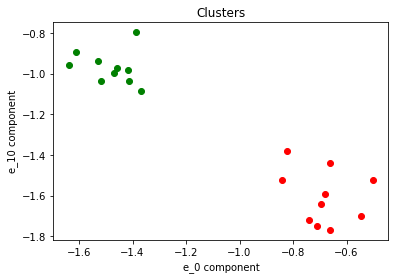

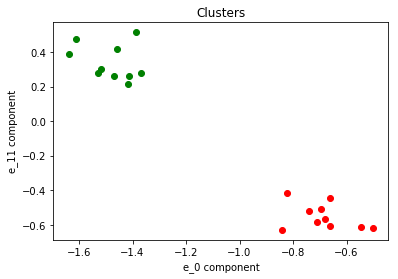

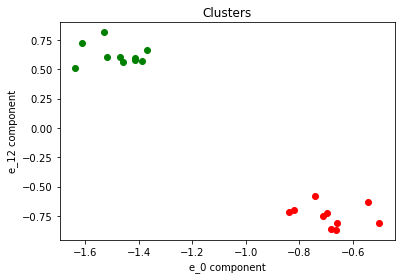

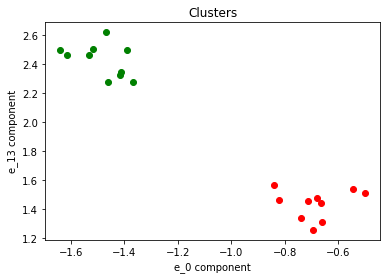

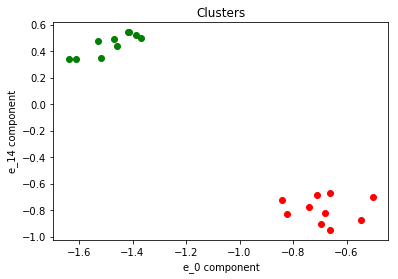

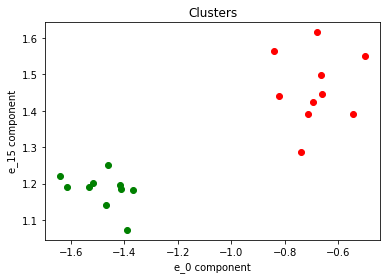

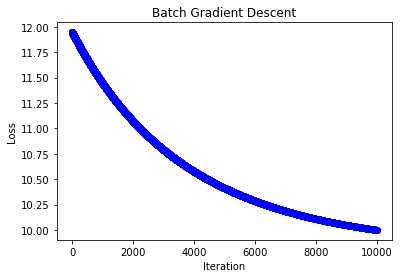

In [46]:
import numpy as np
import matplotlib.pyplot as plt


N = 100
M = 16
A = 0.0000001
E = 500
V = 1
P = 10
S = 0.1
I = 10000


def hypercomplex_conjugate(a):
    c = np.ones(a.shape)
    c[..., 1:] *= -1
    return c * a
    
    
def hypercomplex_conjugate_gradient(a, da):
    return hypercomplex_conjugate(da)
    

def hypercomplex_multiply(a, b):
    if a.shape[-1] == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r) -
                hypercomplex_multiply(
                    hypercomplex_conjugate(s),
                    q)),
                (hypercomplex_multiply(
                    s,
                    p) +
                hypercomplex_multiply(
                    q,
                    hypercomplex_conjugate(r))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(a.shape[-1] // 2)],
            a[..., (a.shape[-1] // 2):],
            b[..., :(a.shape[-1] // 2)],
            b[..., (a.shape[-1] // 2):])
    
    
def hypercomplex_multiply_gradient(a, b, da, db):
    return hypercomplex_multiply(da, b), hypercomplex_multiply(a, db)
    

def hypercomplex_basis_gradient(a):
    basis = np.zeros((a.shape[-1], a.shape[-1]))
    np.fill_diagonal(basis, 1)
    basis = basis.reshape((1, a.shape[-1], a.shape[-1]))
    return basis


dataset_center = np.random.normal(0, 1, (1, M))
cluster_one_center = dataset_center + np.random.normal(0, V, (1, M))
cluster_two_center = dataset_center + np.random.normal(0, V, (1, M))

cluster_one = (np.tile(cluster_one_center, (P, 1))
    + np.random.normal(0, S, (P, M))).reshape((P, 1, M))
cluster_two = (np.tile(cluster_two_center, (P, 1))
    + np.random.normal(0, S, (P, M))).reshape((P, 1, M))

collected_data = np.concatenate([
        cluster_one,
        cluster_two], axis=0)
collected_labels = np.concatenate([
    np.tile(np.array([[[1.0, 0.0]]]), (P, 1, 1)),
    np.tile(np.array([[[0.0, 1.0]]]), (P, 1, 1))], axis=0)

for i in range(1, M):
    
    plt.plot(cluster_one[:, 0, 0], cluster_one[:, 0, i], "go")
    plt.plot(cluster_two[:, 0, 0], cluster_two[:, 0, i], "ro")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("Clusters")
    plt.show()
    
    
class ArtificialNeuralNetwork:
    
    def sigma(self, x):
        a = np.max(x)
        return a + np.log(np.exp(x - a) + np.exp(-a))
    
    def prime(self, x):
        a = np.max(x)
        return np.exp(x - a) / (np.exp(x - a) + np.exp(-a)) 
    
    def __init__(self, topology, alpha):
        self.topology = topology
        self.alpha = alpha
        self.construct()
        
    def construct(self):
        self.weights = []
        self.biases = []
        for a, b in zip(self.topology[:-1], self.topology[1:]):
            self.weights += [np.random.normal(0, 0.1, (a, b))]
            self.biases += [np.random.normal(0, 0.1, (1, 1, b))]
            
    def forward(self, x):
        self.layers = [x]
        for i in range(len(self.weights)):
            x = self.sigma(np.tensordot(
                x,
                self.weights[i],
                1) + self.biases[i])
            self.layers += [x]
        return x
    
    def reverse(self, dx):
        for i in reversed(range(len(self.weights))):
            dx *= self.prime(self.layers[i + 1])
            previous = np.tensordot(dx, self.weights[i].T, 1)
            self.biases[i] -= self.alpha * np.sum(dx, axis=(0, 1), keepdims=True)
            self.weights[i] -= self.alpha * np.tensordot(
                self.layers[i].transpose((2, 0, 1)), dx, 2)
            dx = previous
        return dx
    
    
net = ArtificialNeuralNetwork([M, M, 2], A)
datapoints_loss = []
for i in range(I):
    prediction = net.forward(collected_data)
    datapoints_loss += [np.sum(np.square(prediction - collected_labels))]
    gradient = np.sum(prediction - collected_labels) / 2
    net.reverse(gradient)
    
    
datapoints_loss = np.array(datapoints_loss)
plt.plot(np.arange(1, I+1), datapoints_loss, "bo")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Batch Gradient Descent")
plt.show()     


# TODO: add hypercomplex equivalent and plot loss

